# README
### Introduction
- This jupityr notebook applies a series of transformations to the uncleaned data, with the goal of returning cleaned data 

### The only code block sections that likely require user input are the following:
- Source and Destination Locations
    - Simply update source and destination as desired
- Start each depth-resistance curve when arm first contacts the ground
    - remove_data_prior_to_ground(...) arguments: 
        - subrange_max_resistance
            - An empty list is created and appends resistance subranges with each subrange seperated by resistance=0 value, and only if the subrange maximum resistance is above subrange_max_resistance * df['resistance'].max()
        - spacing_between_ranges:
            - Function remove_data_prior_to_ground(...) reverse iterates through the resistance subrange list, choosing the ground starts index when the next subrange is farther then spacing_between_ranges * len(dp['depth'])
- Remove bad samples
    - (optional) Create a list of indexes which correspond to badly sampled depth-resistance curves 

# Remove old data from folders and create data folders to save plots and cleaned data to

In [1]:
import os
import shutil
from typing import List

clean_folder_names = ['data/uncleaned_plots', 'data/cleaned_data', 'data/cleaned_plots']
def remove_old_data_from_folders(clean_folder_names):
    for folder in clean_folder_names:
        if os.path.exists(folder) and os.path.isdir(folder):
            shutil.rmtree(folder)

create_folder_names = ['data', 'data/uncleaned_plots', 'data/cleaned_data', 'data/cleaned_plots']
def create_data_folders(create_folder_names):
    for folder in create_folder_names:
        if not os.path.exists(folder):
            os.makedirs(folder)  # creates all intermediate directories if needed


# remove_old_data_from_folders(clean_folder_names)
create_data_folders(create_folder_names)

# Source/Destination Path Locations

In [2]:
# do you want to save the plots and cleaned data generated in this file to the path destinations below?
# Keep on false when testing, as it runs much faster when not saving figuresS
save_bool = True

# the source folder of the uncleaned csv data
# uncleaned_data_src = "misc_data/ws23_data"
uncleaned_data_src = "misc_data/ians_paper_data"

# location for saving cleaned csv files
save_cleaned_csv_dst = "data/cleaned_data"

# location for saving uncleaned plots, in folder it'll look like: resistance_depth_1, resistance_depth_2, ...
save_uncleaned_plots_dst = "data/uncleaned_plots"

# location for saving cleaned plots
save_cleaned_plots_dst = "data/cleaned_plots"


# Read in white sands csv files and turn them into dataframes

In [3]:
import os
import pandas as pd
import copy

def load_data(data_src_folder_path, remove_list):
    df_list = []
    filenames_list = []
    for filename in os.listdir(data_src_folder_path):
        if filename in remove_list: 
            print(f'\tremoving filename: {filename}')
            continue
        df = pd.read_csv(f"{data_src_folder_path}/{filename}", skiprows=2)
        df = df[['toeforce_y', 'toe_position_y']] # takes just the two important columns
        df.columns = ["resistance", "depth"] # rename columns
        df_list.append(df)
        filenames_list.append(filename)

    return df_list, filenames_list


remove_list = ['WS23_L3_T1_P_28.csv', 'WS23_L3_T1_P_30.csv', 'WS23_L2_T1_P_0.csv',
            
               '_Fri_Aug__8_06_58_11_2025.csv', '_Thu_Aug__7_08_55_19_2025.csv', '_Thu_Aug__7_08_57_34_2025.csv',
               '_Thu_Aug__7_09_00_35_2025.csv', '_Thu_Aug__7_09_03_29_2025.csv', '_Thu_Aug__7_09_06_09_2025.csv',
               '_Thu_Aug__7_09_12_30_2025.csv', '_Thu_Aug__7_09_18_30_2025.csv', '_Tue_Aug__5_05_54_29_2025.csv']
df_list, filenames_list = load_data(uncleaned_data_src, remove_list)


# desired_filenames = ['_Tue_Aug__5_05_54_29_2025.csv',]
# def find_idxs(find_filename_idxs: list[str], filenames_list: list[str]) -> list[int]:
#     return [i for i, f in enumerate(filenames_list) if f in find_filename_idxs]
# example_plot_idx = find_idxs(desired_filenames, filenames_list)

# index of example depth-resistance curve to plot after each data transformation
plot_idx = 1
print(f"example: \n{df_list[plot_idx]}")


KeyboardInterrupt: 

# Data Visualization

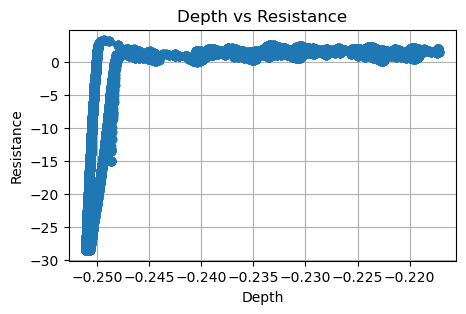

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot(df_list, idx=plot_idx, title='Depth vs Resistance'):
    plt.figure(figsize=(5,3))
    plt.plot(df_list[idx]['depth'], df_list[idx]['resistance'], marker='o', linestyle='-')
    plt.xlabel('Depth')
    plt.ylabel('Resistance')
    plt.title(title)
    plt.grid(True)                    
    plt.show()
    
"""This function will be used at the very end of the cleaning process for comparing before and after cleaning of plots"""
def compare_plots_before_after_cleaning(uncleaned_df_list, cleaned_df_list, removed_list=[], plot_indicies=[]):
    uncleaned_idx = 0
    cleaned_idx = 0
    for i in range(len(uncleaned_df_list)):
        if i not in removed_list:
            if i in plot_indicies:
                print(f"uncleaned idx: {uncleaned_idx}")
                plot(uncleaned_df_list, uncleaned_idx, 'Uncleaned: Depth vs Resistance')
                print(f"cleaned idx: {cleaned_idx}")
                plot(cleaned_df_list, cleaned_idx, 'Cleaned: Depth vs Resistance')
                print("-----------------------------------------------------------")
            uncleaned_idx += 1
            cleaned_idx += 1
        else:
            uncleaned_idx += 1
    
def save_plots(df_list, filenames_list, save_plots_dst, save_bool=False):
    if save_bool:
        combined_columnes = pd.concat(df_list, axis=0)
        for i, df in enumerate(df_list):
            plt.figure(figsize=(8,6))         # Optional: set figure size
            plt.plot(df['depth'], df['resistance'], marker='o', linestyle='-')
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            if "uncleaned" not in save_plots_dst:
                plt.xlim([0, combined_columnes['depth'].max()])
                plt.ylim([0, combined_columnes['resistance'].max()])
            plt.title('Depth vs Resistance')
            plt.grid(True)
            plt.savefig(f"{save_plots_dst}/{filenames_list[i][:-3]}") # sliceing by -3 gets rid of csv name
            plt.close()
    
def generate_box_plots(df_list):
    df_combined_row_wise = pd.concat(df_list, axis=0)
    plt.figure(figsize=(3,2))         # Optional: set figure size
    # ---- resistance ----
    sns.boxplot(x=df_combined_row_wise['resistance'])
    plt.show()
    resistance_series = df_combined_row_wise['resistance']
    # ---- depth ----
    plt.figure(figsize=(3,2))         # Optional: set figure size
    sns.boxplot(x=df_combined_row_wise['depth'])
    plt.show()

def generate_histograms(df_list):
    df_combined_row_wise = pd.concat(df_list, axis=0)
    plt.hist(df_combined_row_wise["resistance"], bins=30, density=True)
    plt.title("Resistance Histogram")
    plt.show()

    plt.hist(df_combined_row_wise["depth"], bins=30, density=True)
    plt.title("Depth Histogram")
    plt.show()

save_plots(df_list, filenames_list, save_uncleaned_plots_dst, save_bool)
plot(df_list)

# Flip curve over y-axis

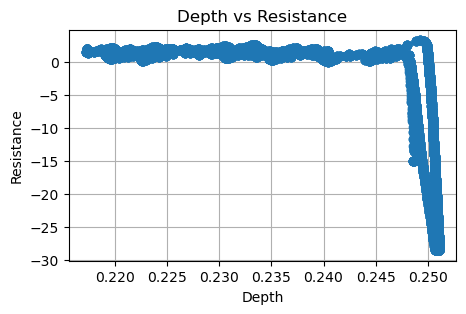

In [ ]:
def flip_over_y_axis(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df['depth'] = -copy_df['depth']
        # if data_file == "mh23":
        #     copy_df['resistance'] = -copy_df['resistance']
        cleaned_df_list.append(copy_df)
    return cleaned_df_list

df_list = flip_over_y_axis(df_list)
plot(df_list)

# Flip over x-axis

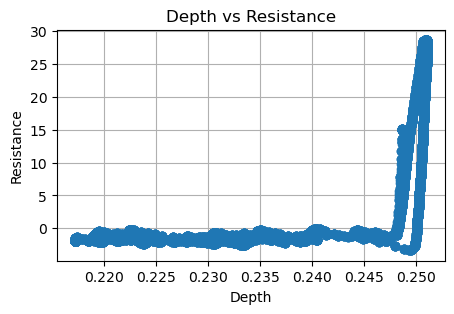

In [ ]:
def flip_over_x_axis(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df['resistance'] = -copy_df['resistance']
        cleaned_df_list.append(copy_df)
    return cleaned_df_list

df_list = flip_over_x_axis(df_list)
plot(df_list)

# Remove all data points after the max depth

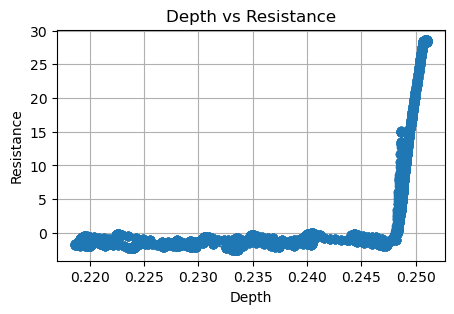

In [ ]:
def remove_points_after_max_depth(df_list):
    cleaned_list = []
    for i, df in enumerate(df_list):
        end_idx = df[df["depth"] == df["depth"].max()].index[0]
        cleaned_df = df.iloc[:end_idx+1]
        cleaned_list.append(cleaned_df)
    return cleaned_list

df_list = remove_points_after_max_depth(df_list)
plot(df_list)

# Remove all data points before min depth

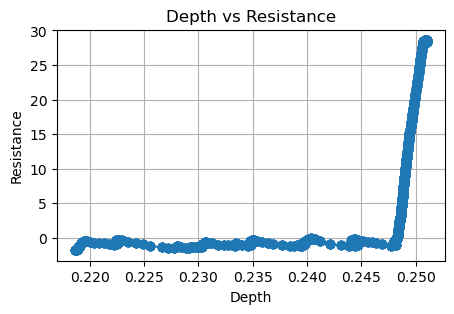

In [ ]:
def remove_points_before_min_depth(df_list):
    cleaned_list = []
    for i, df in enumerate(df_list):
        min_idx = df[df["depth"] == df["depth"].min()].index[0]
        cleaned_df = df.iloc[min_idx:]
        cleaned_list.append(cleaned_df)
    return cleaned_list

# plot(df_list)
df_list = remove_points_before_min_depth(df_list)
plot(df_list)

# Make resistance = 0 for all resistance values < 0

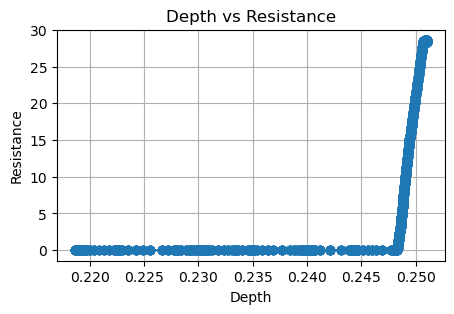

In [ ]:
def make_resistance_min_equal_zero(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df["resistance"] = copy_df["resistance"].clip(lower=0)
        cleaned_df_list.append(copy_df)
    return cleaned_df_list
df_list = make_resistance_min_equal_zero(df_list)
plot(df_list)

# Make sure depth values are only increasing

In [ ]:
def num_dataframes_with_ascending_depth(df_list):
    count = 0
    for df in df_list:
        if not (df['depth'].is_monotonic_increasing and df['depth'].is_unique): 
            count += 1
    return count

def only_increasing_depth(df_list):
    cleaned_df_list = []
    for df in df_list:
        mask = [1]  # keep the first row
        current_max_depth = df['depth'].iloc[0]
        for i in range(1, len(df)):
            if df['depth'].iloc[i] > current_max_depth:
                current_max_depth = df['depth'].iloc[i]
                mask.append(1)
            else:
                mask.append(0)
        mask_series = pd.Series(mask, index=df.index)
        cleaned_df_list.append(df.loc[mask_series.astype(bool)])

    return cleaned_df_list

# show before and after
print(f"Number of dataframes with non-ascending values: {num_dataframes_with_ascending_depth(df_list)}")
# plot(df_list)
df_list = only_increasing_depth(df_list)
print(f"Number of dataframes with non-ascending values: {num_dataframes_with_ascending_depth(df_list)}")
# plot(df_list)

Number of dataframes with non-ascending values: 32
Number of dataframes with non-ascending values: 0


# Start each depth-resistance curve when arm first contacts the ground
- User doesn't need to interact with this code block, as these are supporting functions for a higher level function remove_data_prior_to_ground(...)
- remove_data_prior_to_ground(...) is called and managed by user in code block after the one below

In [ ]:
import pandas as pd
def find_positive_subranges_of_resistance(df):
    ranges_above_zero_list = []
    range_max_height_list = []

    in_range = False
    range_start_idx = None
    range_max_resistance = 0

    for i, res in enumerate(df["resistance"]):
        if res > 0:
            if not in_range:
                # starting a new range
                in_range = True
                if i > 0: range_start_idx = i - 1
                else: range_start_idx = 0
                range_max_resistance = res
            else:
                range_max_resistance = max(range_max_resistance, res)
        elif in_range:
            # end of a positive range
            ranges_above_zero_list.append((range_start_idx, i))
            range_max_height_list.append(range_max_resistance)
            in_range = False

    # handle if last element was part of a range
    if in_range:
        ranges_above_zero_list.append((range_start_idx, len(df["resistance"]) - 1))
        range_max_height_list.append(range_max_resistance)

    return ranges_above_zero_list, range_max_height_list

def filter_subranges(subrange_list, subrange_max_resistance_list, subrange_max_resistance):
    max_resistance_overall = max(subrange_max_resistance_list)
    filtered_subranges = []
    for i, pos_range in enumerate(subrange_list):
        if subrange_max_resistance_list[i] > max_resistance_overall * subrange_max_resistance:
             filtered_subranges.append(pos_range)
    return filtered_subranges

def get_ground_start_idx(df, subrange_max_resistance, spacing_between_ranges, idx):
    subrange_list, subrange_max_resistance_list = find_positive_subranges_of_resistance(df)
    if idx == 51:
        print(f"subrange_list: {subrange_list}\nsubrange_max_resistane_list: {subrange_max_resistance_list}")

    if len(subrange_list) < 1: return 0
    
    # removes subranes below subrange_max_resistance threshold
    filtered_subranges = filter_subranges(subrange_list, subrange_max_resistance_list, subrange_max_resistance)
    if idx == 51:
        # print(f"filter_subranges: {filtered_subranges}")
        depth_value_list = []
        for start, end in filtered_subranges:
            depth_value_list.append((float(df['depth'].iloc[start]), float(df['depth'].iloc[end])))
        # print(f"filter_subranges_values: {depth_value_list}")

    ground_start_idx = filtered_subranges[-1][0] # init ground_start_idx with start of largest curve (last subrange in range_list)
    if len(filtered_subranges) < 2: return ground_start_idx


    # reverse iterate over the filtered subranges and stop when the distance from subrange i to j is too high
    for i in range(len(filtered_subranges)-2, -1, -1): 
        subrange_i_start = df["depth"].iloc[filtered_subranges[i][1]]
        subrange_j_end = df["depth"].iloc[filtered_subranges[i+1][0]]
        if idx == 51: print(f"{subrange_j_end} - {subrange_i_start} > {spacing_between_ranges} * {df['depth'].iloc[-1] - df['depth'].iloc[0]}")
        if subrange_j_end - subrange_i_start > spacing_between_ranges * (df['depth'].iloc[-1] - df['depth'].iloc[0]):
            ground_start_idx = filtered_subranges[i+1][0]
            break # found our final ground_start_idx
        else:
            ground_start_idx = filtered_subranges[i][0]
    if idx == 51: print(f"ground_start_idx: {ground_start_idx}")
    return ground_start_idx

def remove_data_prior_to_ground(df_list, subrange_max_resistance, spacing_between_ranges):
    cleaned_df_list = []
    for idx, df in enumerate(df_list):
        copy_df = df.copy()
        start_idx = get_ground_start_idx(copy_df, subrange_max_resistance, spacing_between_ranges, idx)
        copy_df = copy_df.iloc[start_idx:]
        # copy_df = start_curve_at_ground(copy_df, subrange_max_resistance, spacing_between_ranges)
        copy_df["depth"] = copy_df["depth"] - copy_df['depth'].iloc[0]
        cleaned_df_list.append(copy_df)
    return cleaned_df_list

### Quick Overview
- def remove_data_prior_to_ground(df_list, subrange_max_resistance, spacing_between_subranges)
    - args
        - dp: depth-resistance dataframe
        - subrange_max_resistance
            - user defined threshold used for dropping resistance subranges with a max resistance below this value
            - higher (lower) value means only subranges with high (lower) maximum threshold are considered as the start of the curve
        - spacing_between_ranges 
            - user defined threshold for dropping subranges that have a distance from one another higher then desired
            - higher (lower) value means allowed distances between subranges can be higher (lower)
    - returns
        - dataframe with all data prior to first contact with ground removed and adjusted to start at 0

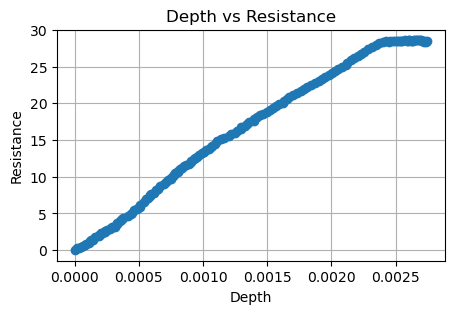

In [ ]:
# this works fantastic for crsust breaks
pre_find_ground_df_list = copy.deepcopy(df_list)
# df_list = remove_data_prior_to_ground(df_list, subrange_max_resistance=0.1, spacing_between_ranges=0.1)
df_list = remove_data_prior_to_ground(df_list, subrange_max_resistance=0.1, spacing_between_ranges=0.05)
plot(df_list)

# Interpolation to uniformly resample points from curve

Before interpolation


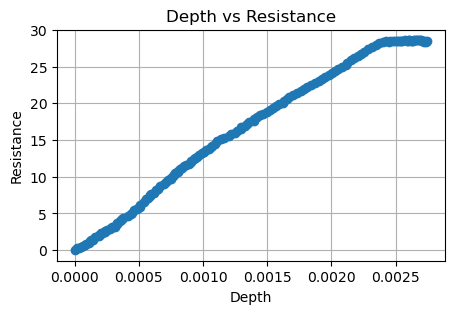

After interpolation


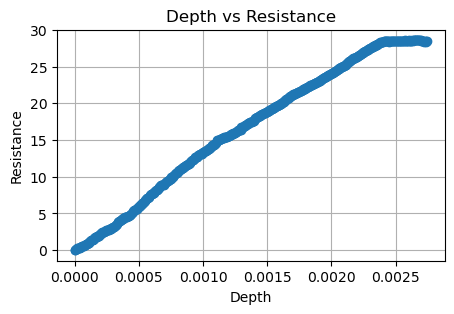

In [ ]:
import numpy as np
def interpolate(df_list, num_points):
    interp_df_list = []
    for df in df_list:
        x_intervals = np.linspace(0, df['depth'].max(), num_points, endpoint=True) # 100 points between 0 and trunc_level
        y_new = np.interp(x_intervals, df["depth"], df["resistance"])
        new_df = pd.DataFrame({'depth': x_intervals, 'resistance': y_new})
        interp_df_list.append(new_df)
    return interp_df_list

print("Before interpolation")
plot(df_list)
df_list = interpolate(df_list, 500)
print("After interpolation")
plot(df_list)

# Save photos of all cleaned curves

In [ ]:
save_plots(df_list, filenames_list, save_cleaned_plots_dst, save_bool)

# Save the cleaned csv files and filenames

In [ ]:
def save_data_csv(final_df_list, filenames_list, save_dst, save_bool: bool):
    if save_bool:
        for i in range(len(final_df_list)):
            final_df_list[i].to_csv(f"{save_dst}/{filenames_list[i]}")

save_data_csv(df_list, filenames_list, save_dst=save_cleaned_csv_dst, save_bool=save_bool)


# Print out before and after cleaning of plots

In [ ]:
# crust_break_indicies = [6,7,13,15,23,31,32,39,47,51,62,68,73]
flatter_curves = [5, 7, 13, 14, 16, 31, 43, 45, 47, 51, 64, 71, 72, 73]

# # problems = [14,23,68]

# compare_plots_before_after_cleaning(uncleaned_df_list=pre_find_ground_df_list, cleaned_df_list=df_list, 
#         removed_list=remove_list, plot_indicies=flatter_curves)